In [1]:
import tensorflow as tf
print(tf.__version__)
print("Num GPUs Available:", len(tf.config.experimental.list_physical_devices('GPU')))

2.16.2
Num GPUs Available: 1


In [2]:
import os
import pandas as pd
import random
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score, f1_score, precision_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import Callback
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Pre processamento dos Dados

In [3]:
def read_and_rename_file(file_path):
    df = pd.read_csv(file_path, skiprows=22, header=None, delimiter='\t')
    df.columns = ['indices', 'velocidade', 'AceleracaoX', 'AceleracaoY', 'AceleracaoZ']
    return df

def determine_damage(filename):
    if filename.startswith("H"):
        return "Saudável"
    elif "0.5X" in filename:
        return "Moderado"
    else:
        return "Severo"

def is_variable_speed(filename):
    return 1 if "VS" in filename else 0

def calculate_variable_speed(index):
    sampling_frequency = 25600
    time = index
    time_in_cycle = time % 2

    if time_in_cycle <= 1.0:
        speed = time_in_cycle * 40
    else:
        speed = 40 - (time_in_cycle - 1) * 40

    return round(speed * 2) / 2

def extract_condition(df, filename):
    if "VS" in filename:
        df['Condição'] = df['indices'].apply(calculate_variable_speed)
    else:
        condition = filename.split('_')[-1].replace('.xls', '').replace('Hz', '')
        df['Condição'] = int(condition) if condition.isdigit() else None
    return df

In [4]:
# Diretório com os arquivos
data_dir = "/Users/enzooliveira/Pessoal/VS CODE/IC/raw data"

# Lista para armazenar os dataframes
all_dataframes = []

# Processar cada arquivo
for filename in os.listdir(data_dir):
    if filename.endswith(".xls"):
        file_path = os.path.join(data_dir, filename)
        df = read_and_rename_file(file_path)

        df['VelocidadeConstante'] = is_variable_speed(filename)
        df['Dano'] = determine_damage(filename)

        # Aplicar a lógica da condição
        df = extract_condition(df, filename)

        # Adicionar uma coluna com o nome do arquivo
        df['Arquivo'] = filename

        # Adicionar o dataframe à lista
        all_dataframes.append(df)

# Concatenar todos os dataframes em um único dataframe
df= pd.concat(all_dataframes, ignore_index=True)

df

/var/folders/2y/w0k2g57j60scys4qmyx_fx0r0000gn/T/ipykernel_30856/3429283940.py:26: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df= pd.concat(all_dataframes, ignore_index=True)


,indices,velocidade,AceleracaoX,AceleracaoY,AceleracaoZ,VelocidadeConstante,Dano,Condição,Arquivo
0,0.000000,0.062811,-0.005853,0.034844,-0.055663,0,Severo,40.0,B_40Hz.xls
1,0.000039,0.065399,0.009108,0.037469,-0.050143,0,Severo,40.0,B_40Hz.xls
2,0.000078,0.069251,0.018196,0.040567,-0.015191,0,Severo,40.0,B_40Hz.xls
3,0.000117,0.068802,0.050685,0.025236,-0.071849,0,Severo,40.0,B_40Hz.xls
4,0.000156,0.066454,-0.023585,0.024446,-0.000025,0,Severo,40.0,B_40Hz.xls
...,...,...,...,...,...,...,...,...,...
25952251,10.239805,5.002699,-0.281512,0.179481,-0.175507,0,Moderado,60.0,0.5X_C_60Hz.xls
25952252,10.239844,5.000125,0.013449,0.185089,-0.234294,0,Moderado,60.0,0.5X_C_60Hz.xls
25952253,10.239883,4.999646,0.109414,0.174463,-0.062894,0,Moderado,60.0,0.5X_C_60Hz.xls
25952254,10.239922,4.997449,0.092863,0.082801,-0.049218,0,Moderado,60.0,0.5X_C_60Hz.xls


In [5]:
# Remover as colunas 'indices' e 'velocidade'
df = df.drop(columns=['indices', 'velocidade'])

print(df.head())  # Mostrar as primeiras linhas do DataFrame sem as colunas

   AceleracaoX  AceleracaoY  AceleracaoZ  VelocidadeConstante    Dano  \
0    -0.005853     0.034844    -0.055663                    0  Severo   
1     0.009108     0.037469    -0.050143                    0  Severo   
2     0.018196     0.040567    -0.015191                    0  Severo   
3     0.050685     0.025236    -0.071849                    0  Severo   
4    -0.023585     0.024446    -0.000025                    0  Severo   

   Condição     Arquivo  
0      40.0  B_40Hz.xls  
1      40.0  B_40Hz.xls  
2      40.0  B_40Hz.xls  
3      40.0  B_40Hz.xls  
4      40.0  B_40Hz.xls  


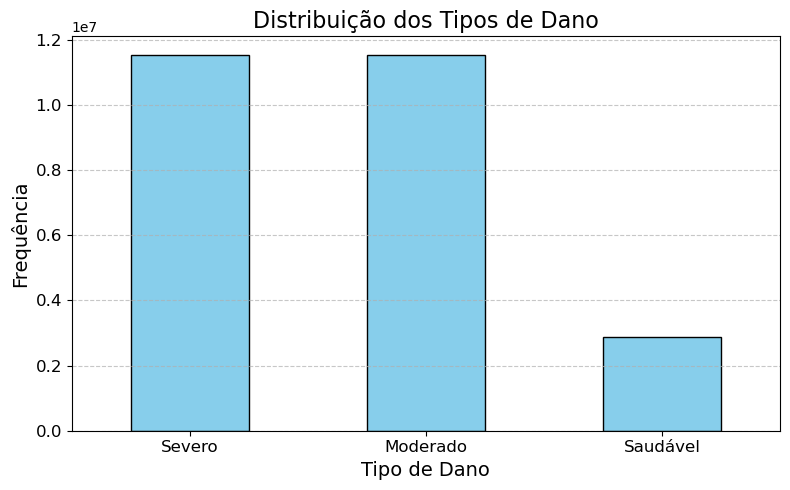

In [6]:
import matplotlib.pyplot as plt

# Contagem dos diferentes tipos de "Dano"
dano_counts = df['Dano'].value_counts()

# Plotando os tipos de "Dano"
plt.figure(figsize=(8, 5))
dano_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribuição dos Tipos de Dano', fontsize=16)
plt.xlabel('Tipo de Dano', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [7]:
# Criar uma nova coluna 'Dano_Binário'
df['Dano_Binário'] = df['Dano'].apply(lambda x: 1 if x in ['Moderado', 'Severo'] else 0)

# Verificar os resultados
print(df[['Dano', 'Dano_Binário']].head())

     Dano  Dano_Binário
0  Severo             1
1  Severo             1
2  Severo             1
3  Severo             1
4  Severo             1


In [8]:
df.head()

,AceleracaoX,AceleracaoY,AceleracaoZ,VelocidadeConstante,Dano,Condição,Arquivo,Dano_Binário
0,-0.005853,0.034844,-0.055663,0,Severo,40.0,B_40Hz.xls,1
1,0.009108,0.037469,-0.050143,0,Severo,40.0,B_40Hz.xls,1
2,0.018196,0.040567,-0.015191,0,Severo,40.0,B_40Hz.xls,1
3,0.050685,0.025236,-0.071849,0,Severo,40.0,B_40Hz.xls,1
4,-0.023585,0.024446,-0.000025,0,Severo,40.0,B_40Hz.xls,1


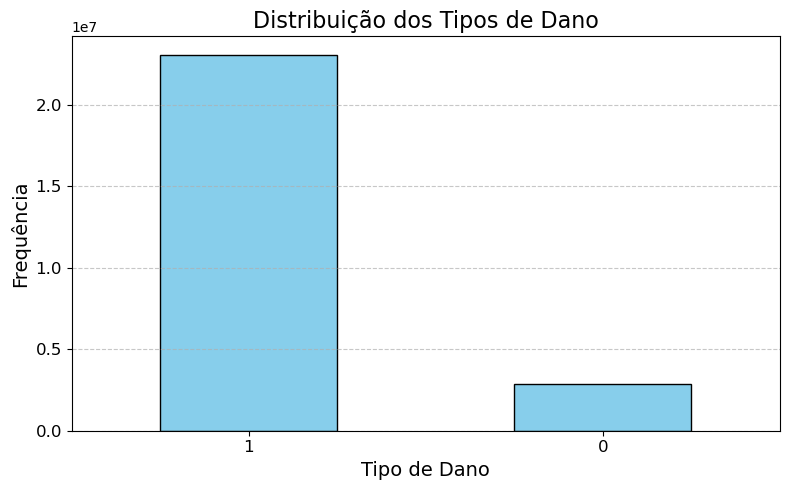

In [9]:
import matplotlib.pyplot as plt

# Contagem dos diferentes tipos de "Dano"
dano_counts = df['Dano_Binário'].value_counts()

# Plotando os tipos de "Dano"
plt.figure(figsize=(8, 5))
dano_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Distribuição dos Tipos de Dano', fontsize=16)
plt.xlabel('Tipo de Dano', fontsize=14)
plt.ylabel('Frequência', fontsize=14)
plt.xticks(rotation=0, fontsize=12)
plt.yticks(fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [10]:
# Remover as colunas 'indices' e 'velocidade'
df = df.drop(columns=['Dano'])

print(df.head())  # Mostrar as primeiras linhas do DataFrame sem as colunas

   AceleracaoX  AceleracaoY  AceleracaoZ  VelocidadeConstante  Condição  \
0    -0.005853     0.034844    -0.055663                    0      40.0   
1     0.009108     0.037469    -0.050143                    0      40.0   
2     0.018196     0.040567    -0.015191                    0      40.0   
3     0.050685     0.025236    -0.071849                    0      40.0   
4    -0.023585     0.024446    -0.000025                    0      40.0   

      Arquivo  Dano_Binário  
0  B_40Hz.xls             1  
1  B_40Hz.xls             1  
2  B_40Hz.xls             1  
3  B_40Hz.xls             1  
4  B_40Hz.xls             1  


In [11]:
# Imprimir as diferentes condições na coluna 'Condição'
unique_conditions = df['Condição'].unique()
print("Condições diferentes na coluna 'Condição':", unique_conditions)

Condições diferentes na coluna 'Condição': [40.  75.  80.  30.  35.  70.  60.   nan 25.   0.   0.5  1.   1.5  2.
  2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5  7.   7.5  8.   8.5  9.
  9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5 14.  14.5 15.  15.5 16.
 16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5 21.  21.5 22.  22.5 23.
 23.5 24.  24.5 25.5 26.  26.5 27.  27.5 28.  28.5 29.  29.5 30.5 31.
 31.5 32.  32.5 33.  33.5 34.  34.5 35.5 36.  36.5 37.  37.5 38.  38.5
 39.  39.5 65. ]


In [12]:
# Filtrar e listar os arquivos que possuem velocidade constante (VelocidadeConstante == 1)
constant_speed_files = df[df['VelocidadeConstante'] == 1]['Arquivo'].unique()
print("\nArquivos com velocidade constante:", constant_speed_files)


Arquivos com velocidade constante: ['0.5X_C_VS_0_40_0Hz.xls' 'I_VS_0_40_0Hz.xls' '0.5X_B_VS_0_40_0Hz.xls'
 'H_VS_0_40_0Hz.xls' 'O_VS_0_40_0Hz.xls' '0.5X_O_VS_0_40_0Hz.xls'
 'B_VS_0_40_0Hz.xls' 'C_VS_0_40_0Hz.xls' '0.5X_I_VS_0_40_0Hz.xls']


In [13]:
# Exibe as linhas do DataFrame que possuem valores NaN
rows_with_nan = df[df.isnull().any(axis=1)]
print("Linhas com NaN:")
print(rows_with_nan)

Linhas com NaN:
         AceleracaoX  AceleracaoY  AceleracaoZ  VelocidadeConstante  Condição  \
4456448     0.008474    -0.001685    -0.025114                    0       NaN   
4456449     0.005671     0.002940    -0.026641                    0       NaN   
4456450     0.004506     0.003463    -0.022146                    0       NaN   
4456451    -0.014623    -0.000940    -0.025220                    0       NaN   
4456452    -0.028677    -0.014313    -0.016837                    0       NaN   
...              ...          ...          ...                  ...       ...   
4718587    -0.005294    -0.000752    -0.004059                    0       NaN   
4718588    -0.008208    -0.008494     0.003126                    0       NaN   
4718589    -0.015472    -0.017029     0.006428                    0       NaN   
4718590    -0.028042    -0.023906     0.005474                    0       NaN   
4718591    -0.045072    -0.030570     0.001794                    0       NaN   

           

In [14]:
# Substituir todos os valores NaN por 25.0
df = df.fillna(25.0)

# Verificar se ainda há valores NaN
print("Há valores NaN após a substituição?", df.isnull().values.any())

Há valores NaN após a substituição? False


In [15]:
# Filtrar o DataFrame para VelocidadeConstante == 0
filtered_df = df[df['VelocidadeConstante'] == 0]

# Obter as condições únicas na coluna 'Condição' para os casos com VelocidadeConstante == 0
unique_conditions = filtered_df['Condição'].unique()

# Imprimir as condições únicas
print("Condições únicas com VelocidadeConstante == 0:", unique_conditions)

Condições únicas com VelocidadeConstante == 0: [40. 75. 80. 30. 35. 70. 60. 25. 20. 65.]


In [16]:
df = df.drop(columns=['VelocidadeConstante'])

print(df.head())  # Mostrar as primeiras linhas do DataFrame sem as colunas

   AceleracaoX  AceleracaoY  AceleracaoZ  Condição     Arquivo  Dano_Binário
0    -0.005853     0.034844    -0.055663      40.0  B_40Hz.xls             1
1     0.009108     0.037469    -0.050143      40.0  B_40Hz.xls             1
2     0.018196     0.040567    -0.015191      40.0  B_40Hz.xls             1
3     0.050685     0.025236    -0.071849      40.0  B_40Hz.xls             1
4    -0.023585     0.024446    -0.000025      40.0  B_40Hz.xls             1


# Primeiro experimento (11 arquivos saudaveis 11 danificados para treino) resto para teste

In [17]:
# Criar o DataFrame df_healthy_train com arquivos saudáveis (Dano_Binário == 0)
df_healthy_train = df[df['Dano_Binário'] == 0]

# Criar o DataFrame df_damaged_train com os arquivos especificados
damaged_files = ['I_20Hz.xls', 'B_25Hz.xls', 'C_30Hz.xls', 'O_35Hz.xls', 'I_40Hz.xls',
                 'B_60Hz.xls', 'C_65Hz.xls', 'O_70Hz.xls', 'I_75Hz.xls', 'B_80Hz.xls', 'I_VS_0_40_0Hz.xls']
df_damaged_train = df[df['Arquivo'].isin(damaged_files)]

# Garantir que ambos os DataFrames têm o mesmo número de linhas
assert df_healthy_train.shape[0] == df_damaged_train.shape[0], "Os DataFrames têm tamanhos diferentes!"

# Mostrar informações sobre os DataFrames criados
print(f"Tamanho de df_healthy_train: {df_healthy_train.shape[0]} linhas")
print(f"Tamanho de df_damaged_train: {df_damaged_train.shape[0]} linhas")

Tamanho de df_healthy_train: 2883584 linhas
Tamanho de df_damaged_train: 2883584 linhas


In [18]:
df_damaged_train.head()

,AceleracaoX,AceleracaoY,AceleracaoZ,Condição,Arquivo,Dano_Binário
1310720,0.031825,-0.515205,-0.177599,80.0,B_80Hz.xls,1
1310721,-0.092407,-0.414178,-0.071121,80.0,B_80Hz.xls,1
1310722,-0.132668,-0.198323,-0.241078,80.0,B_80Hz.xls,1
1310723,-0.246418,0.086982,-0.245376,80.0,B_80Hz.xls,1
1310724,-0.231284,0.253594,-0.209047,80.0,B_80Hz.xls,1


In [19]:
df_healthy_train.head()

,AceleracaoX,AceleracaoY,AceleracaoZ,Condição,Arquivo,Dano_Binário
2883584,-0.239702,0.279940,0.145551,80.0,H_80Hz.xls,0
2883585,-0.268383,0.293183,-0.097255,80.0,H_80Hz.xls,0
2883586,-0.228635,0.468781,-0.121527,80.0,H_80Hz.xls,0
2883587,0.025226,0.413938,0.040759,80.0,H_80Hz.xls,0
2883588,0.254310,0.139315,-0.188217,80.0,H_80Hz.xls,0


In [20]:
# Criar o DataFrame df_damaged_test excluindo os arquivos especificados
df_damaged_test = df[(df['Dano_Binário'] == 1) & (~df['Arquivo'].isin(damaged_files))]

# Criar 7 cópias de df_healthy_train e concatená-las
df_1 = df_healthy_train.copy()
df_2 = df_healthy_train.copy()
df_3 = df_healthy_train.copy()
df_4 = df_healthy_train.copy()
df_5 = df_healthy_train.copy()
df_6 = df_healthy_train.copy()
df_7 = df_healthy_train.copy()

# Concatenar os 7 DataFrames em um único DataFrame
df_healthy_test = pd.concat([df_1, df_2, df_3, df_4, df_5, df_6, df_7], ignore_index=True)

# Garantir que df_healthy_test e df_damaged_test têm o mesmo número de linhas
assert df_healthy_test.shape[0] == df_damaged_test.shape[0], "Os DataFrames têm tamanhos diferentes!"

# Mostrar informações sobre os DataFrames criados
print(f"Tamanho de df_damaged_test: {df_damaged_test.shape[0]} linhas")
print(f"Tamanho de df_healthy_test: {df_healthy_test.shape[0]} linhas")

Tamanho de df_damaged_test: 20185088 linhas
Tamanho de df_healthy_test: 20185088 linhas


In [21]:
df_damaged_test.head()

,AceleracaoX,AceleracaoY,AceleracaoZ,Condição,Arquivo,Dano_Binário
0,-0.005853,0.034844,-0.055663,40.0,B_40Hz.xls,1
1,0.009108,0.037469,-0.050143,40.0,B_40Hz.xls,1
2,0.018196,0.040567,-0.015191,40.0,B_40Hz.xls,1
3,0.050685,0.025236,-0.071849,40.0,B_40Hz.xls,1
4,-0.023585,0.024446,-0.000025,40.0,B_40Hz.xls,1


In [24]:
df_healthy_test.head()

,AceleracaoX,AceleracaoY,AceleracaoZ,Condição,Arquivo,Dano_Binário
0,-0.239702,0.279940,0.145551,80.0,H_80Hz.xls,0
1,-0.268383,0.293183,-0.097255,80.0,H_80Hz.xls,0
2,-0.228635,0.468781,-0.121527,80.0,H_80Hz.xls,0
3,0.025226,0.413938,0.040759,80.0,H_80Hz.xls,0
4,0.254310,0.139315,-0.188217,80.0,H_80Hz.xls,0


In [25]:
def create_sliding_windows(df, window_size, step_size, label):
    """
    Cria janelas deslizantes de tamanho `window_size` com passo `step_size`.
    """
    X, y = [], []
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[i:i + window_size]
        X.append(window[['AceleracaoX', 'AceleracaoY', 'AceleracaoZ', 'Condição']].values)
        y.append(label)
    return np.array(X), np.array(y)

# Configurações das janelas deslizantes
window_size = 200
step_size = 50

# Função para processar arquivos e gerar janelas deslizantes
def process_files(df, window_size, step_size):
    X_list, y_list = [], []
    for arquivo in df['Arquivo'].unique():
        arquivo_df = df[df['Arquivo'] == arquivo]
        label = arquivo_df['Dano_Binário'].iloc[0]  # Obter o label do arquivo
        X, y = create_sliding_windows(arquivo_df, window_size, step_size, label)
        X_list.append(X)
        y_list.append(y)
    return np.vstack(X_list), np.hstack(y_list)

In [22]:
# 🔹 Definir seed apenas para NumPy
SEED = 42
np.random.seed(SEED)

# 🔹 Configuração para evitar estouro de memória na GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuração de memória dinâmica para GPU ativada.")
    except RuntimeError as e:
        print(e)

# 🔹 Callback personalizado para progresso do treinamento
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nIniciando Época {epoch + 1}/{self.params['epochs']}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Época {epoch + 1} finalizada. Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")

    def on_batch_end(self, batch, logs=None):
        if batch % 50 == 0:  # Ajuste a frequência conforme necessário
            print(f"  Batch {batch} concluído. Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")

# 🔹 Função para criar janelas deslizantes
def create_sliding_windows(df, window_size, step_size, label):
    """
    Cria janelas deslizantes de tamanho `window_size` com passo `step_size`.
    """
    X, y = [], []
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[i:i + window_size]
        X.append(window[['AceleracaoX', 'AceleracaoY', 'AceleracaoZ', 'Condição']].values)
        y.append(label)
    return np.array(X), np.array(y)

# 🔹 Configurações das janelas deslizantes
window_size = 200
step_size = 50

# 🔹 Função para processar os arquivos
def process_files(df, window_size, step_size):
    X_list, y_list = [], []
    for arquivo in df['Arquivo'].unique():
        arquivo_df = df[df['Arquivo'] == arquivo]
        label = arquivo_df['Dano_Binário'].iloc[0]  # Obter o label do arquivo
        X, y = create_sliding_windows(arquivo_df, window_size, step_size, label)
        X_list.append(X)
        y_list.append(y)
    return np.vstack(X_list), np.hstack(y_list)

# 🔹 Gerar dados de treinamento
X_train, y_train = process_files(pd.concat([df_healthy_train, df_damaged_train]), window_size, step_size)

# 🔹 Gerar dados de teste
X_test, y_test = process_files(pd.concat([df_healthy_test, df_damaged_test]), window_size, step_size)

# 🔹 Embaralhar os dados de treinamento com seed fixa no NumPy
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)  # Apenas NumPy com seed definida no início
X_train = X_train[indices_train]
y_train = y_train[indices_train]

# 🔹 Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

Configuração de memória dinâmica para GPU ativada.


In [26]:

# Definir o modelo LSTM
model = Sequential([
    LSTM(128, input_shape=(window_size, 4), activation='tanh', return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo utilizando a GPU
try:
    with tf.device('/GPU:0'):
        print("Treinando no GPU...")
        history = model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.1,
            callbacks=[TrainingProgressCallback()]
        )
except RuntimeError as e:
    print(f"Erro ao treinar no GPU: {e}")
    print("Tentando no CPU...")
    with tf.device('/CPU:0'):
        history = model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.1,
            callbacks=[TrainingProgressCallback()]
        )

2025-02-14 15:22:29.260063: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2025-02-14 15:22:29.260126: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2025-02-14 15:22:29.260148: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2025-02-14 15:22:29.260408: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-02-14 15:22:29.260433: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)
/Users/enzooliveira/mambaforge/envs/ml_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. W

Treinando no GPU...

Iniciando Época 1/10
Epoch 1/10


2025-02-14 15:22:30.019432: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  Batch 0 concluído. Loss: 0.7011, Accuracy: 0.4688
  49/3242 ━━━━━━━━━━━━━━━━━━━━ 56s 18ms/step - accuracy: 0.5115 - loss: 0.6864  Batch 50 concluído. Loss: 0.6714, Accuracy: 0.5404
 100/3242 ━━━━━━━━━━━━━━━━━━━━ 56s 18ms/step - accuracy: 0.5283 - loss: 0.6773  Batch 100 concluído. Loss: 0.6673, Accuracy: 0.5458
 148/3242 ━━━━━━━━━━━━━━━━━━━━ 55s 18ms/step - accuracy: 0.5359 - loss: 0.6727  Batch 150 concluído. Loss: 0.6619, Accuracy: 0.5569
 199/3242 ━━━━━━━━━━━━━━━━━━━━ 54s 18ms/step - accuracy: 0.5417 - loss: 0.6699  Batch 200 concluído. Loss: 0.6622, Accuracy: 0.5591
 249/3242 ━━━━━━━━━━━━━━━━━━━━ 54s 18ms/step - accuracy: 0.5453 - loss: 0.6684  Batch 250 concluído. Loss: 0.6631, Accuracy: 0.5609
 299/3242 ━━━━━━━━━━━━━━━━━━━━ 53s 18ms/step - accuracy: 0.5481 - loss: 0.6673  Batch 300 concluído. Loss: 0.6604, Accuracy: 0.5633
 348/3242 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - accuracy: 0.5504 - loss: 0.6662  Batch 350 concluído. Loss: 0.6582, Accuracy: 0.5660
 399/3242 ━━━━━━━━━━━━━━━

In [27]:
# Avaliar o modelo
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibir métricas
metrics = {
    "MSE": [mse],
    "MAE": [mae],
    "Accuracy": [accuracy],
    "Balanced Accuracy": [balanced_accuracy],
    "F1 Score": [f1],
    "Precision": [precision]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

25221/25221 ━━━━━━━━━━━━━━━━━━━━ 245s 10ms/step
        MSE       MAE  Accuracy  Balanced Accuracy  F1 Score  Precision
0  0.109977  0.109977  0.890023            0.88999  0.877377   0.990968


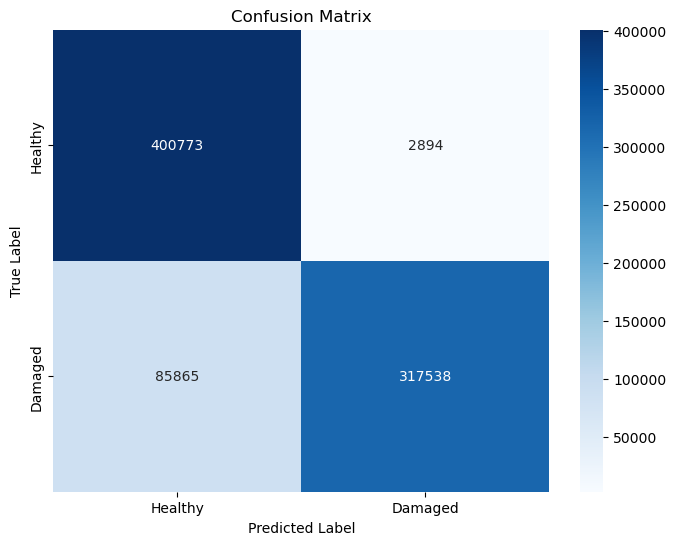

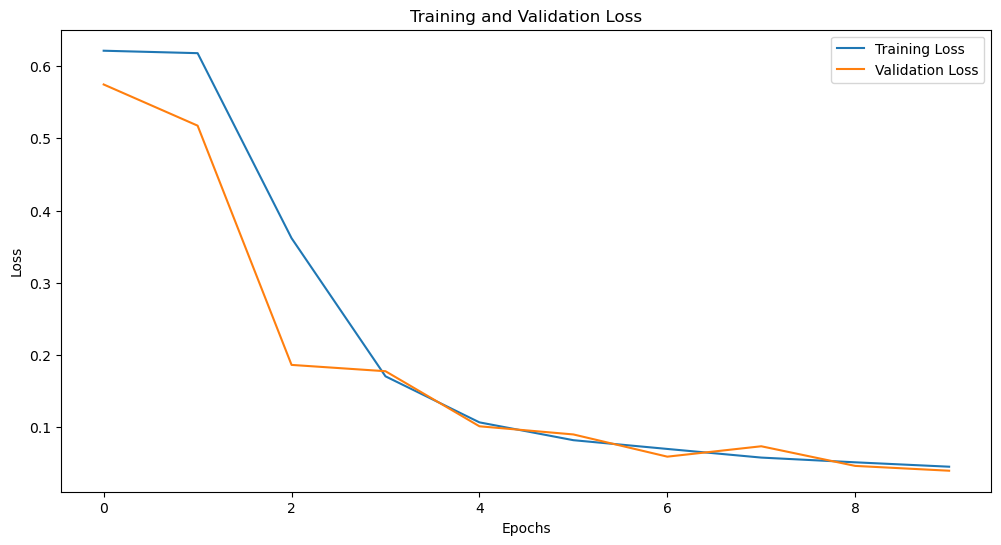

In [28]:
# Plotar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Damaged'], yticklabels=['Healthy', 'Damaged'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plotar gráficos de perda
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [29]:
# 🔹 Definir seed apenas para NumPy
SEED = 42
np.random.seed(SEED)

# 🔹 Configuração para evitar estouro de memória na GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuração de memória dinâmica para GPU ativada.")
    except RuntimeError as e:
        print(e)

# 🔹 Callback personalizado para progresso do treinamento
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nIniciando Época {epoch + 1}/{self.params['epochs']}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Época {epoch + 1} finalizada. Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")

    def on_batch_end(self, batch, logs=None):
        if batch % 50 == 0:
            print(f"  Batch {batch} concluído. Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")

# 🔹 Função para criar janelas deslizantes
def create_sliding_windows(df, window_size, step_size, label):
    X, y = [], []
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[i:i + window_size]
        X.append(window[['AceleracaoX', 'AceleracaoY', 'AceleracaoZ', 'Condição']].values)
        y.append(label)
    return np.array(X), np.array(y)

# 🔹 Configurações das janelas deslizantes
window_size = 200
step_size = 50

# 🔹 Função para processar os arquivos
def process_files(df, window_size, step_size):
    X_list, y_list = [], []
    for arquivo in df['Arquivo'].unique():
        arquivo_df = df[df['Arquivo'] == arquivo]
        label = arquivo_df['Dano_Binário'].iloc[0]
        X, y = create_sliding_windows(arquivo_df, window_size, step_size, label)
        X_list.append(X)
        y_list.append(y)
    return np.vstack(X_list), np.hstack(y_list)

# 🔹 Gerar dados de treinamento
X_train, y_train = process_files(pd.concat([df_healthy_train, df_damaged_train]), window_size, step_size)

# 🔹 Gerar dados de teste
X_test, y_test = process_files(pd.concat([df_healthy_test, df_damaged_test]), window_size, step_size)

# 🔹 Embaralhar os dados de treinamento com seed fixa no NumPy
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)  # Apenas NumPy com seed definida no início
X_train = X_train[indices_train]
y_train = y_train[indices_train]

# 🔹 Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# 🔹 Definir o modelo LSTM
model = Sequential([
    LSTM(128, input_shape=(window_size, 4), activation='tanh', return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# 🔹 Treinar o modelo utilizando a GPU
try:
    with tf.device('/GPU:0'):
        print("Treinando no GPU...")
        history = model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.1,
            callbacks=[TrainingProgressCallback()]
        )
except RuntimeError as e:
    print(f"Erro ao treinar no GPU: {e}")
    print("Tentando no CPU...")
    with tf.device('/CPU:0'):
        history = model.fit(
            X_train,
            y_train,
            epochs=10,
            batch_size=32,
            validation_split=0.1,
            callbacks=[TrainingProgressCallback()]
        )

Configuração de memória dinâmica para GPU ativada.


/Users/enzooliveira/mambaforge/envs/ml_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Treinando no GPU...

Iniciando Época 1/10
Epoch 1/10
  Batch 0 concluído. Loss: 0.6992, Accuracy: 0.5625
  48/3242 ━━━━━━━━━━━━━━━━━━━━ 1:16 24ms/step - accuracy: 0.5337 - loss: 0.6841  Batch 50 concluído. Loss: 0.6762, Accuracy: 0.5460
 100/3242 ━━━━━━━━━━━━━━━━━━━━ 1:15 24ms/step - accuracy: 0.5435 - loss: 0.6788  Batch 100 concluído. Loss: 0.6719, Accuracy: 0.5566
 149/3242 ━━━━━━━━━━━━━━━━━━━━ 1:14 24ms/step - accuracy: 0.5503 - loss: 0.6750  Batch 150 concluído. Loss: 0.6642, Accuracy: 0.5702
 199/3242 ━━━━━━━━━━━━━━━━━━━━ 1:12 24ms/step - accuracy: 0.5558 - loss: 0.6718  Batch 200 concluído. Loss: 0.6609, Accuracy: 0.5726
 249/3242 ━━━━━━━━━━━━━━━━━━━━ 1:10 24ms/step - accuracy: 0.5594 - loss: 0.6695  Batch 250 concluído. Loss: 0.6597, Accuracy: 0.5762
 300/3242 ━━━━━━━━━━━━━━━━━━━━ 1:09 23ms/step - accuracy: 0.5624 - loss: 0.6676  Batch 300 concluído. Loss: 0.6571, Accuracy: 0.5771
 348/3242 ━━━━━━━━━━━━━━━━━━━━ 1:08 24ms/step - accuracy: 0.5645 - loss: 0.6670  Batch 350 concluí

In [30]:
# Avaliar o modelo
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibir métricas
metrics = {
    "MSE": [mse],
    "MAE": [mae],
    "Accuracy": [accuracy],
    "Balanced Accuracy": [balanced_accuracy],
    "F1 Score": [f1],
    "Precision": [precision]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

25221/25221 ━━━━━━━━━━━━━━━━━━━━ 240s 10ms/step
        MSE       MAE  Accuracy  Balanced Accuracy  F1 Score  Precision
0  0.107134  0.107134  0.892866           0.892832   0.88071   0.993019


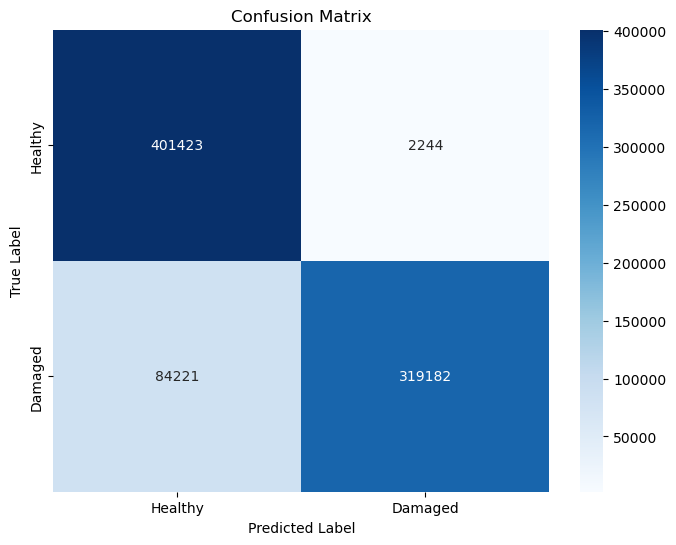

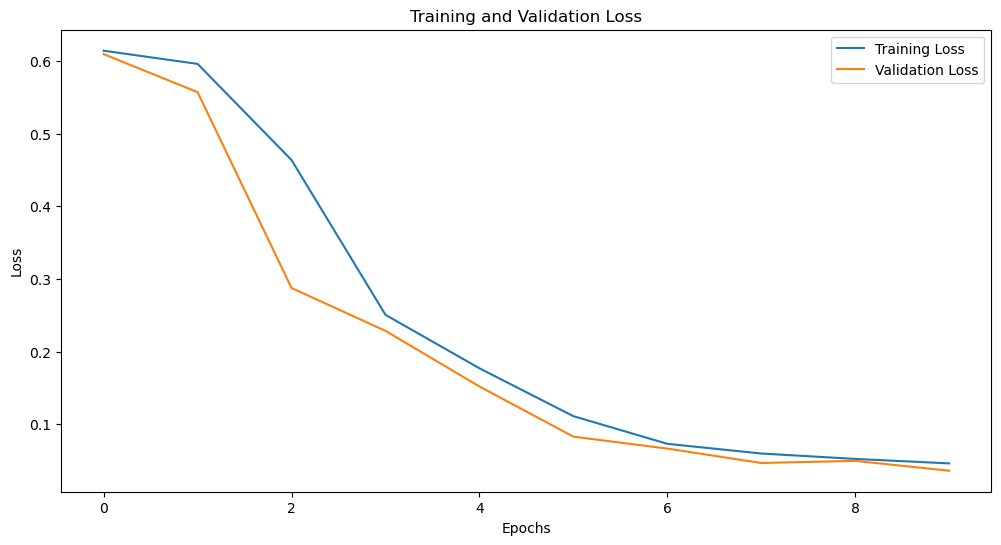

In [31]:
# Plotar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Damaged'], yticklabels=['Healthy', 'Damaged'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plotar gráficos de perda
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [32]:
# 🔹 Definir seed para reprodutibilidade
SEED = 42
np.random.seed(SEED)     # Seed para NumPy (shuffle, geração de números)

# Configuração para evitar estouro de memória na GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuração de memória dinâmica para GPU ativada.")
    except RuntimeError as e:
        print(e)

# Callback personalizado para progresso do treinamento
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nIniciando Época {epoch + 1}/{self.params['epochs']}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Época {epoch + 1} finalizada. Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")

    def on_batch_end(self, batch, logs=None):
        if batch % 50 == 0:  # Ajuste a frequência conforme necessário
            print(f"  Batch {batch} concluído. Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")

# Função para criar janelas deslizantes
def create_sliding_windows(df, window_size, step_size, label):
    """
    Cria janelas deslizantes de tamanho `window_size` com passo `step_size`.
    """
    X, y = [], []
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[i:i + window_size]
        X.append(window[['AceleracaoX', 'AceleracaoY', 'AceleracaoZ','Condição']].values)
        y.append(label)
    return np.array(X), np.array(y)

# Configurações das janelas deslizantes
window_size = 200
step_size = 50

# Função para processar os arquivos
def process_files(df, window_size, step_size):
    X_list, y_list = [], []
    for arquivo in df['Arquivo'].unique():
        arquivo_df = df[df['Arquivo'] == arquivo]
        label = arquivo_df['Dano_Binário'].iloc[0]  # Obter o label do arquivo
        X, y = create_sliding_windows(arquivo_df, window_size, step_size, label)
        X_list.append(X)
        y_list.append(y)
    return np.vstack(X_list), np.hstack(y_list)

# Gerar dados de treinamento
X_train, y_train = process_files(pd.concat([df_healthy_train, df_damaged_train]), window_size, step_size)

# Gerar dados de teste
X_test, y_test = process_files(pd.concat([df_healthy_test, df_damaged_test]), window_size, step_size)

# Embaralhar os dados de treinamento
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)
X_train = X_train[indices_train]
y_train = y_train[indices_train]

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Definir o modelo LSTM
model = Sequential([
    LSTM(128, input_shape=(window_size, 4), activation='tanh', return_sequences=False),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Treinar o modelo utilizando a GPU
try:
    with tf.device('/GPU:0'):
        print("Treinando no GPU...")
        history = model.fit(
            X_train,
            y_train,
            epochs=40,
            batch_size=32,
            validation_split=0.1,
            callbacks=[TrainingProgressCallback()]
        )
except RuntimeError as e:
    print(f"Erro ao treinar no GPU: {e}")
    print("Tentando no CPU...")
    with tf.device('/CPU:0'):
        history = model.fit(
            X_train,
            y_train,
            epochs=40,
            batch_size=32,
            validation_split=0.1,
            callbacks=[TrainingProgressCallback()]
        )

Configuração de memória dinâmica para GPU ativada.


/Users/enzooliveira/mambaforge/envs/ml_env/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Treinando no GPU...

Iniciando Época 1/40
Epoch 1/40
  Batch 0 concluído. Loss: 0.7060, Accuracy: 0.4375
  49/3242 ━━━━━━━━━━━━━━━━━━━━ 58s 18ms/step - accuracy: 0.5524 - loss: 0.6830  Batch 50 concluído. Loss: 0.6749, Accuracy: 0.5496
 100/3242 ━━━━━━━━━━━━━━━━━━━━ 56s 18ms/step - accuracy: 0.5531 - loss: 0.6761  Batch 100 concluído. Loss: 0.6615, Accuracy: 0.5653
 149/3242 ━━━━━━━━━━━━━━━━━━━━ 55s 18ms/step - accuracy: 0.5583 - loss: 0.6729  Batch 150 concluído. Loss: 0.6664, Accuracy: 0.5739
 200/3242 ━━━━━━━━━━━━━━━━━━━━ 54s 18ms/step - accuracy: 0.5624 - loss: 0.6710  Batch 200 concluído. Loss: 0.6652, Accuracy: 0.5740
 250/3242 ━━━━━━━━━━━━━━━━━━━━ 53s 18ms/step - accuracy: 0.5650 - loss: 0.6697  Batch 250 concluído. Loss: 0.6633, Accuracy: 0.5787
 299/3242 ━━━━━━━━━━━━━━━━━━━━ 52s 18ms/step - accuracy: 0.5673 - loss: 0.6686  Batch 300 concluído. Loss: 0.6620, Accuracy: 0.5792
 350/3242 ━━━━━━━━━━━━━━━━━━━━ 51s 18ms/step - accuracy: 0.5694 - loss: 0.6673  Batch 350 concluído. Los

In [33]:
# Avaliar o modelo
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibir métricas
metrics = {
    "MSE": [mse],
    "MAE": [mae],
    "Accuracy": [accuracy],
    "Balanced Accuracy": [balanced_accuracy],
    "F1 Score": [f1],
    "Precision": [precision]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

25221/25221 ━━━━━━━━━━━━━━━━━━━━ 119s 5ms/step
        MSE       MAE  Accuracy  Balanced Accuracy  F1 Score  Precision
0  0.075457  0.075457  0.924543           0.924521  0.919052   0.990809


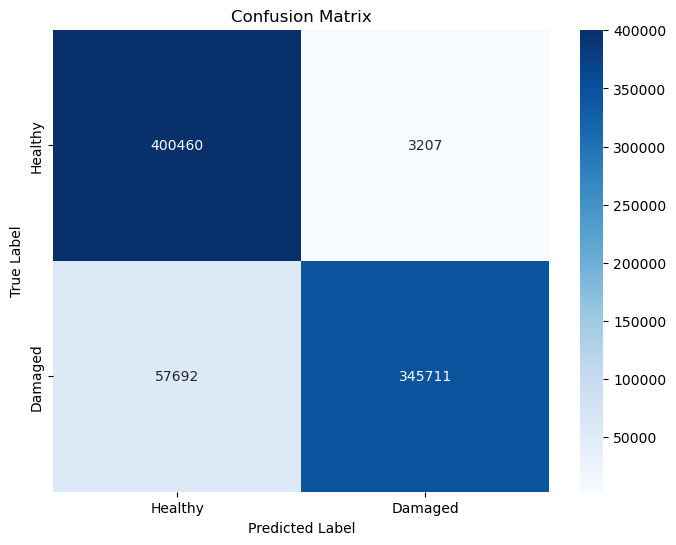

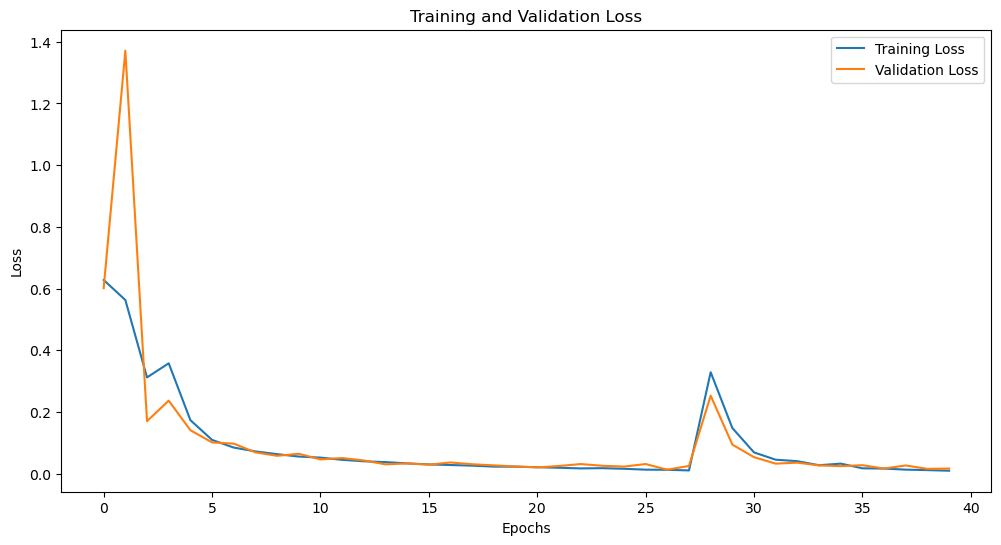

: 

In [ ]:
# Plotar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Damaged'], yticklabels=['Healthy', 'Damaged'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plotar gráficos de perda
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Bidirectional, BatchNormalization, Conv1D, MaxPooling1D, Flatten, Attention, Input
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score, f1_score, precision_score, confusion_matrix

SEED = 42
np.random.seed(SEED)     # Seed para NumPy (shuffle, geração de números)

    # Configuração para evitar estouro de memória na GPU
    gpus = tf.config.list_physical_devices('GPU')
    if gpus:
        try:
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            print("Configuração de memória dinâmica para GPU ativada.")
        except RuntimeError as e:
            print(e)

# Definir arquiteturas de LSTM
def create_lstm_model(architecture, input_shape):
    model = Sequential()
    
    if architecture == "simple":
        model.add(LSTM(256, input_shape=input_shape, activation='tanh'))
    
    elif architecture == "stacked":
        model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
        model.add(LSTM(64, return_sequences=False))
    
    elif architecture == "dropout":
        model.add(LSTM(128, input_shape=input_shape, activation='tanh', return_sequences=True))
        model.add(Dropout(0.3))
        model.add(LSTM(64, return_sequences=False))
    
    elif architecture == "bidirectional":
        model.add(Bidirectional(LSTM(128, return_sequences=True), input_shape=input_shape))
        model.add(Bidirectional(LSTM(64, return_sequences=False)))
    
    elif architecture == "batch_norm":
        model.add(LSTM(128, return_sequences=True, input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(LSTM(64, return_sequences=False))
    
    elif architecture == "dense_layers":
        model.add(LSTM(128, input_shape=input_shape, return_sequences=False))
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
    
    elif architecture == "attention":
        inputs = Input(shape=input_shape)
        lstm_out = LSTM(128, return_sequences=True)(inputs)
        attn_layer = Attention()([lstm_out, lstm_out])
        lstm_out2 = LSTM(64, return_sequences=False)(attn_layer)
        outputs = Dense(1, activation='sigmoid')(lstm_out2)
        model = tf.keras.Model(inputs, outputs)
    
    elif architecture == "cnn_lstm":
        model.add(Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape))
        model.add(MaxPooling1D(pool_size=2))
        model.add(LSTM(128, return_sequences=False))
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Lista de arquiteturas
architectures = ["simple", "stacked", "dropout", "bidirectional", "batch_norm", "dense_layers", "attention", "cnn_lstm"]

# Input shape para os modelos
input_shape = (200, 3)

# Treinar e avaliar cada modelo
results = []
for arch in architectures:
    print(f"\nTreinando arquitetura: {arch}")
    model = create_lstm_model(arch, input_shape)
    
    try:
        with tf.device('/GPU:0'):
            history = model.fit(
                X_train, y_train,
                epochs=10, batch_size=32,
                validation_split=0.1,
                verbose=1
            )
    except:
        with tf.device('/CPU:0'):
            history = model.fit(
                X_train, y_train,
                epochs=10, batch_size=32,
                validation_split=0.1,
                verbose=1
            )
    
    # Avaliar o modelo
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    results.append([arch, mse, mae, accuracy, balanced_acc, f1, precision])

# Criar DataFrame com resultados
results_df = pd.DataFrame(results, columns=["Architecture", "MSE", "MAE", "Accuracy", "Balanced Accuracy", "F1 Score", "Precision"])
print(results_df)


# Usando agora CNN para comparar


In [ ]:
SEED = 42
np.random.seed(SEED)     # Seed para NumPy (shuffle, geração de números)

# Função para criar janelas deslizantes com formato adequado para CNN
def create_sliding_windows_for_cnn(df, window_size, step_size, label):
    """
    Cria janelas deslizantes de tamanho `window_size` com passo `step_size`, adequadas para CNN.
    A entrada para a CNN será 3D, com formato (janela, 4 canais).
    """
    X, y = [], []
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[i:i + window_size]
        # Para CNN, a entrada precisa ser (janela, 4 características) como 'imagem' 2D
        X.append(window[['AceleracaoX', 'AceleracaoY', 'AceleracaoZ', 'Condição']].values)
        y.append(label)
    return np.array(X), np.array(y)

# Ajustar a função de processamento dos arquivos para usar a versão para CNN
def process_files_for_cnn(df, window_size, step_size):
    X_list, y_list = [], []
    for arquivo in df['Arquivo'].unique():
        arquivo_df = df[df['Arquivo'] == arquivo]
        label = arquivo_df['Dano_Binário'].iloc[0]  # Obter o label do arquivo
        X, y = create_sliding_windows_for_cnn(arquivo_df, window_size, step_size, label)
        X_list.append(X)
        y_list.append(y)
    return np.vstack(X_list), np.hstack(y_list)

# Gerar dados de treinamento
X_train, y_train = process_files_for_cnn(pd.concat([df_healthy_train, df_damaged_train]), window_size, step_size)

# Gerar dados de teste
X_test, y_test = process_files_for_cnn(pd.concat([df_healthy_test, df_damaged_test]), window_size, step_size)

# Embaralhar os dados de treinamento
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)
X_train = X_train[indices_train]
y_train = y_train[indices_train]

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Alterar a forma de X_train e X_test para (samples, height, width, channels)
# Aqui "height" é o "window_size" (tempo), "width" é o número de características (4), e "channels" será 1, já que é uma entrada 2D simples
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Definir o modelo CNN1D para séries temporais
model = Sequential([
    Conv1D(128, 3, activation='relu', input_shape=(window_size, 4)),  # Camada convolucional 1D
    Flatten(),  # Achatar a saída
    Dense(1, activation='sigmoid')  # Camada densa com 1 neurônio para classificação binária
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callback personalizado para progresso do treinamento
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nIniciando Época {epoch + 1}/{self.params['epochs']}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Época {epoch + 1} finalizada. Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")

    def on_batch_end(self, batch, logs=None):
        if batch % 50 == 0:  # Ajuste a frequência conforme necessário
            print(f"  Batch {batch} concluído. Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")

# Treinar o modelo utilizando a GPU
try:
    with tf.device('/GPU:0'):
        print("Treinando no GPU...")
        history = model.fit(
            X_train,
            y_train,
            epochs=40,
            batch_size=32,
            validation_split=0.1,
            callbacks=[TrainingProgressCallback()]
        )
except RuntimeError as e:
    print(f"Erro ao treinar no GPU: {e}")
    print("Tentando no CPU...")
    with tf.device('/CPU:0'):
        history = model.fit(
            X_train,
            y_train,
            epochs=40,
            batch_size=32,
            validation_split=0.1,
            callbacks=[TrainingProgressCallback()]
        )

/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
2024-12-03 13:12:52.569866: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-12-03 13:12:52.569914: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-12-03 13:12:52.569922: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-12-03 13:12:52.570145: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-12-03 13:12:52.570169: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_fa

Treinando no GPU...

Iniciando Época 1/40
Epoch 1/40


2024-12-03 13:12:53.158257: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


  Batch 0 concluído. Loss: 0.6691, Accuracy: 0.5625
  47/3242 ━━━━━━━━━━━━━━━━━━━━ 18s 6ms/step - accuracy: 0.5423 - loss: 0.7012  Batch 50 concluído. Loss: 0.6699, Accuracy: 0.5790
  96/3242 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.5760 - loss: 0.6751  Batch 100 concluído. Loss: 0.6326, Accuracy: 0.6306
 145/3242 ━━━━━━━━━━━━━━━━━━━━ 17s 6ms/step - accuracy: 0.5971 - loss: 0.6580  Batch 150 concluído. Loss: 0.6148, Accuracy: 0.6488
 194/3242 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.6115 - loss: 0.6453  Batch 200 concluído. Loss: 0.5969, Accuracy: 0.6650
 241/3242 ━━━━━━━━━━━━━━━━━━━━ 16s 6ms/step - accuracy: 0.6228 - loss: 0.6350  Batch 250 concluído. Loss: 0.5888, Accuracy: 0.6780
 300/3242 ━━━━━━━━━━━━━━━━━━━━ 16s 5ms/step - accuracy: 0.6338 - loss: 0.6262  Batch 300 concluído. Loss: 0.5875, Accuracy: 0.6820
 348/3242 ━━━━━━━━━━━━━━━━━━━━ 15s 5ms/step - accuracy: 0.6407 - loss: 0.6205  Batch 350 concluído. Loss: 0.5812, Accuracy: 0.6860
 397/3242 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
# Avaliar o modelo
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibir métricas
metrics = {
    "MSE": [mse],
    "MAE": [mae],
    "Accuracy": [accuracy],
    "Balanced Accuracy": [balanced_accuracy],
    "F1 Score": [f1],
    "Precision": [precision]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

25221/25221 ━━━━━━━━━━━━━━━━━━━━ 21s 830us/step
        MSE       MAE  Accuracy  Balanced Accuracy  F1 Score  Precision
0  0.091819  0.091819  0.908181            0.90816  0.901842    0.96836


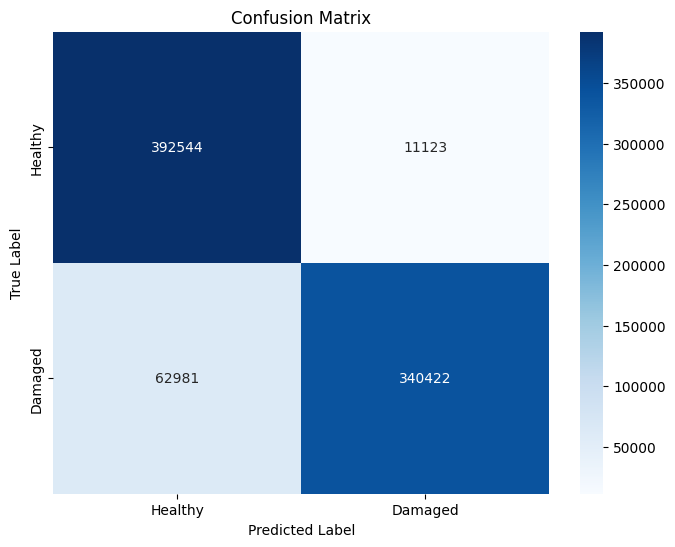

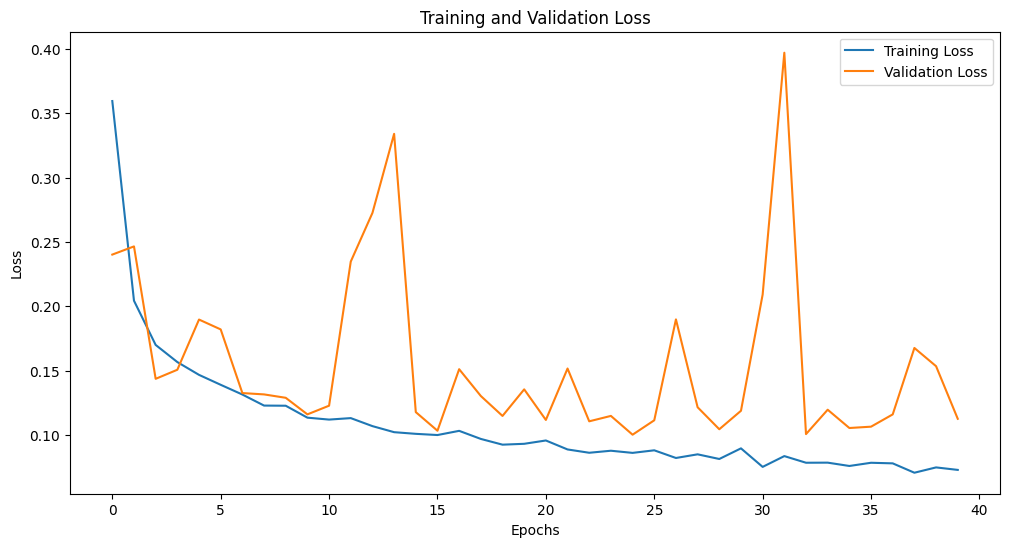

In [ ]:
# Plotar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Damaged'], yticklabels=['Healthy', 'Damaged'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plotar gráficos de perda
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
SEED = 42
np.random.seed(SEED)     # Seed para NumPy (shuffle, geração de números)

# Função para criar janelas deslizantes com formato adequado para CNN
def create_sliding_windows_for_cnn(df, window_size, step_size, label):
    """
    Cria janelas deslizantes de tamanho `window_size` com passo `step_size`, adequadas para CNN.
    A entrada para a CNN será 3D, com formato (janela, 4 canais).
    """
    X, y = [], []
    for i in range(0, len(df) - window_size + 1, step_size):
        window = df.iloc[i:i + window_size]
        # Para CNN, a entrada precisa ser (janela, 4 características) como 'imagem' 2D
        X.append(window[['AceleracaoX', 'AceleracaoY', 'AceleracaoZ', 'Condição']].values)
        y.append(label)
    return np.array(X), np.array(y)

# Ajustar a função de processamento dos arquivos para usar a versão para CNN
def process_files_for_cnn(df, window_size, step_size):
    X_list, y_list = [], []
    for arquivo in df['Arquivo'].unique():
        arquivo_df = df[df['Arquivo'] == arquivo]
        label = arquivo_df['Dano_Binário'].iloc[0]  # Obter o label do arquivo
        X, y = create_sliding_windows_for_cnn(arquivo_df, window_size, step_size, label)
        X_list.append(X)
        y_list.append(y)
    return np.vstack(X_list), np.hstack(y_list)

# Gerar dados de treinamento
X_train, y_train = process_files_for_cnn(pd.concat([df_healthy_train, df_damaged_train]), window_size, step_size)

# Gerar dados de teste
X_test, y_test = process_files_for_cnn(pd.concat([df_healthy_test, df_damaged_test]), window_size, step_size)

# Embaralhar os dados de treinamento
indices_train = np.arange(X_train.shape[0])
np.random.shuffle(indices_train)
X_train = X_train[indices_train]
y_train = y_train[indices_train]

# Normalizar os dados
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
X_test = scaler.transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

# Alterar a forma de X_train e X_test para (samples, height, width, channels)
# Aqui "height" é o "window_size" (tempo), "width" é o número de características (4), e "channels" será 1, já que é uma entrada 2D simples
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

# Definir o modelo CNN1D para séries temporais
model = Sequential([
    Conv1D(32, 2, activation='relu', input_shape=(window_size, 4)),  # Camada convolucional 1D com kernel (2,)
    MaxPooling1D(pool_size=1),  # Usando pooling 1D com pool size (1) para evitar redução excessiva
    Conv1D(64, 2, activation='relu'),  # Segunda camada convolucional 1D
    MaxPooling1D(pool_size=1),  # Usando pooling 1D
    Flatten(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')  # Camada de saída para classificação binária
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Callback personalizado para progresso do treinamento
class TrainingProgressCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs=None):
        print(f"\nIniciando Época {epoch + 1}/{self.params['epochs']}")

    def on_epoch_end(self, epoch, logs=None):
        print(f"Época {epoch + 1} finalizada. Loss: {logs['loss']:.4f}, Val Loss: {logs['val_loss']:.4f}, Val Accuracy: {logs['val_accuracy']:.4f}")

    def on_batch_end(self, batch, logs=None):
        if batch % 50 == 0:  # Ajuste a frequência conforme necessário
            print(f"  Batch {batch} concluído. Loss: {logs['loss']:.4f}, Accuracy: {logs['accuracy']:.4f}")

# Treinar o modelo utilizando a GPU
try:
    with tf.device('/GPU:0'):
        print("Treinando no GPU...")
        history = model.fit(
            X_train,
            y_train,
            epochs=40,
            batch_size=32,
            validation_split=0.1,
            callbacks=[TrainingProgressCallback()]
        )
except RuntimeError as e:
    print(f"Erro ao treinar no GPU: {e}")
    print("Tentando no CPU...")
    with tf.device('/CPU:0'):
        history = model.fit(
            X_train,
            y_train,
            epochs=40,
            batch_size=32,
            validation_split=0.1,
            callbacks=[TrainingProgressCallback()]
        )

/opt/anaconda3/envs/tf-metal/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Treinando no GPU...

Iniciando Época 1/40
Epoch 1/40
  Batch 0 concluído. Loss: 0.6798, Accuracy: 0.3125
  48/3242 ━━━━━━━━━━━━━━━━━━━━ 29s 9ms/step - accuracy: 0.4870 - loss: 0.8183  Batch 50 concluído. Loss: 0.6806, Accuracy: 0.5784
  96/3242 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.5503 - loss: 0.7317  Batch 100 concluído. Loss: 0.6087, Accuracy: 0.6467
 150/3242 ━━━━━━━━━━━━━━━━━━━━ 28s 9ms/step - accuracy: 0.5880 - loss: 0.6822  Batch 150 concluído. Loss: 0.5779, Accuracy: 0.6658
 199/3242 ━━━━━━━━━━━━━━━━━━━━ 27s 9ms/step - accuracy: 0.6100 - loss: 0.6531  Batch 200 concluído. Loss: 0.5505, Accuracy: 0.6886
 247/3242 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.6276 - loss: 0.6310  Batch 250 concluído. Loss: 0.5251, Accuracy: 0.7164
 296/3242 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - accuracy: 0.6438 - loss: 0.6118  Batch 300 concluído. Loss: 0.5057, Accuracy: 0.7337
 350/3242 ━━━━━━━━━━━━━━━━━━━━ 25s 9ms/step - accuracy: 0.6588 - loss: 0.5940  Batch 350 concluído. Loss: 0.48

In [ ]:
# Avaliar o modelo
y_pred = (model.predict(X_test) > 0.5).astype("int32")

# Calcular métricas
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)
balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

# Exibir métricas
metrics = {
    "MSE": [mse],
    "MAE": [mae],
    "Accuracy": [accuracy],
    "Balanced Accuracy": [balanced_accuracy],
    "F1 Score": [f1],
    "Precision": [precision]
}

metrics_df = pd.DataFrame(metrics)
print(metrics_df)

25221/25221 ━━━━━━━━━━━━━━━━━━━━ 29s 1ms/step
        MSE       MAE  Accuracy  Balanced Accuracy  F1 Score  Precision
0  0.072655  0.072655  0.927345           0.927322   0.92205   0.994141


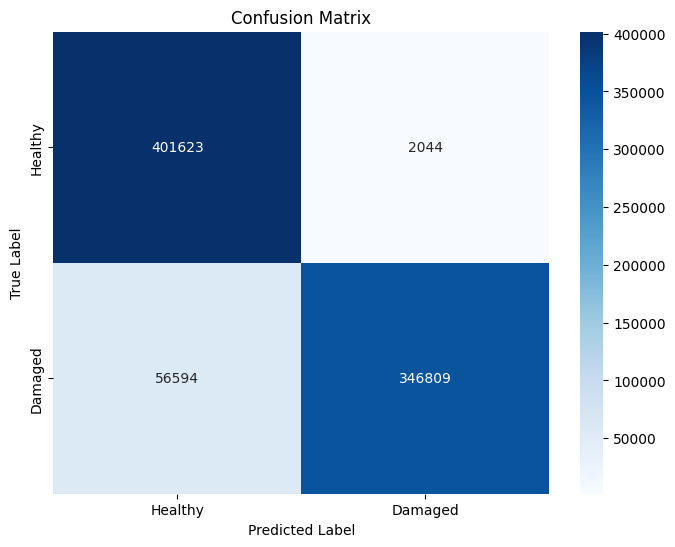

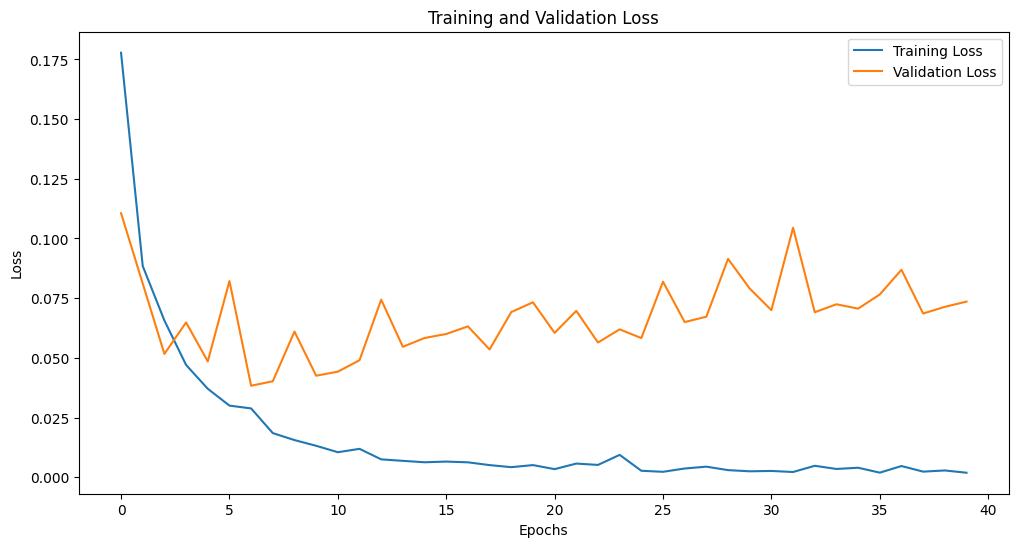

In [ ]:
# Plotar matriz de confusão
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=['Healthy', 'Damaged'], yticklabels=['Healthy', 'Damaged'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

# Plotar gráficos de perda
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling1D, Input, Activation
from tensorflow.keras.optimizers import Adam
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, accuracy_score, balanced_accuracy_score, f1_score, precision_score, confusion_matrix

SEED = 42
np.random.seed(SEED)     # Seed para NumPy (shuffle, geração de números)

# Configuração para evitar estouro de memória na GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print("Configuração de memória dinâmica para GPU ativada.")
    except RuntimeError as e:
        print(e)

# Definir arquiteturas de CNN
def create_cnn_model(architecture, input_shape):
    model = Sequential()
    
    if architecture == "basic":
        model.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
        model.add(Flatten())
    
    elif architecture == "deep":
        model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
        model.add(Conv1D(128, 3, activation='relu'))
        model.add(Flatten())
    
    elif architecture == "dropout":
        model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
        model.add(Dropout(0.3))
        model.add(Conv1D(128, 3, activation='relu'))
        model.add(Flatten())
    
    elif architecture == "batch_norm":
        model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
        model.add(BatchNormalization())
        model.add(Conv1D(128, 3, activation='relu'))
        model.add(Flatten())
    
    elif architecture == "maxpool":
        model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
        model.add(MaxPooling1D(2))
        model.add(Conv1D(128, 3, activation='relu'))
        model.add(Flatten())
    
    elif architecture == "global_avg":
        model.add(Conv1D(64, 3, activation='relu', input_shape=input_shape))
        model.add(GlobalAveragePooling1D())
    
    elif architecture == "extra_dense":
        model.add(Conv1D(128, 3, activation='relu', input_shape=input_shape))
        model.add(Flatten())
        model.add(Dense(64, activation='relu'))
        model.add(Dense(32, activation='relu'))
    
    elif architecture == "residual":
        inputs = Input(shape=input_shape)
        x = Conv1D(64, 3, activation='relu', padding='same')(inputs)
        x = Conv1D(64, 3, activation='relu', padding='same')(x)
        x = Conv1D(64, 3, activation='relu', padding='same')(x)
        x = tf.keras.layers.add([x, inputs])
        x = Flatten()(x)
        outputs = Dense(1, activation='sigmoid')(x)
        model = tf.keras.Model(inputs, outputs)
    else:
        raise ValueError("Invalid architecture")
    
    model.add(Dense(1, activation='sigmoid'))
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=['accuracy'])
    return model

# Lista de arquiteturas
architectures = ["basic", "deep", "dropout", "batch_norm", "maxpool", "global_avg", "extra_dense", "residual"]

# Input shape para os modelos
input_shape = (200, 4)

# Treinar e avaliar cada modelo
results = []
for arch in architectures:
    print(f"\nTreinando arquitetura: {arch}")
    model = create_cnn_model(arch, input_shape)
    
    try:
        with tf.device('/GPU:0'):
            history = model.fit(
                X_train, y_train,
                epochs=40, batch_size=32,
                validation_split=0.1,
                verbose=1
            )
    except:
        with tf.device('/CPU:0'):
            history = model.fit(
                X_train, y_train,
                epochs=40, batch_size=32,
                validation_split=0.1,
                verbose=1
            )
    
    # Avaliar o modelo
    y_pred = (model.predict(X_test) > 0.5).astype("int32")
    
    mse = mean_squared_error(y_test, y_pred)
    mae = mean_absolute_error(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    
    results.append([arch, mse, mae, accuracy, balanced_acc, f1, precision])

# Criar DataFrame com resultados
results_df = pd.DataFrame(results, columns=["Architecture", "MSE", "MAE", "Accuracy", "Balanced Accuracy", "F1 Score", "Precision"])
print(results_df)
